In [1]:
import numpy as np
import pickle
import time 
import timeit
import shutil 
import h5py
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
from functools import partial
import glob
import os
import pandas as pd
import statistics as sta
from scipy.stats import circstd, circmean
from scipy.signal import savgol_filter
import ruptures as rpt

In [27]:
pol1_full = np.load("/home/lars/vmodel_output/Pred_attack=front_pol_astr_dphi.npy")
pol2_full = np.load("/home/lars/vmodel_output/NoPred_relax.npy")

(20, 20, 30, 2800)

In [28]:
rel_time_hm = np.zeros((20,20,30))
nruns = 30
time = len(pol1_full[0,0,0,:])
method="bs"

for ii in range(20):
    for jj in range(20):
    
        pol2 = pol2_full[ii,jj,:,:]
        pol = pol1_full[ii,jj,:,:]
    ################################################################################
        ################## THE IMPORTANT STUFF STARTS BELOW ############################
        ################################################################################

        ## ALL THE CODE BELOW - COMPUTES THE RELAXATION TIME ###
        mean_pol0=np.transpose(pol2).mean(axis=1)
        mean_pol1=[np.mean(mean_pol0)]*time
        flat_list = [item for sublist in pol2 for item in sublist]
        std_pol1=np.std(flat_list)
    
        for k in range(nruns):
           # t_end_fnt=[index for index,value in enumerate(FNT[k]) if value == 1][-1]
            points=pol[k]         
            if method=="dp":
                #Changepoint detection with dynamic programming search method
                model = "l1"  
                algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(points)
            elif method=="bs":
                #Changepoint detection with the Binary Segmentation search method
                model = "l2"  
                algo = rpt.Binseg(model=model).fit(points)
            my_bkps = algo.predict(n_bkps=10)
          #  relax_t[k] = my_bkps[-2]-t_end_fnt  #### <----- WE DO NOT DO IT SINCE IT CAN INCREASE THE VARIATION IN THE VALUES, WE WANT TO KEEP IT CLEAN
           
           #### Lower Control Limits
            yhat2 = savgol_filter(mean_pol1-3*std_pol1-points, 333, 2)
            l2=np.where(yhat2 <0)[0]
            if len(np.array(l2))>0:
                i=1
                while (l2[i]-l2[i-1]==1) and (i<len(np.array(l2))-1):
                      i=i+1
            else:
                i=0

            if i==len(np.array(l2))-1 or i==0:
                rel_time_hm[ii,jj,k]=np.nan # time
            else:
                rel_time_hm[ii,jj,k]=l2[i]



In [13]:

perc_75 = np.nanpercentile(rel_time_hm, 75)

rel_filtered = np.copy(rel_time_hm)[rel_time_hm >= perc_75]
rel_filtered[rel_filtered >= perc_75] = "NaN"

reltime_mean = np.nanmean(rel_time_hm[:,:,:], axis= 2)



/tmp/ipykernel_7085/4214535950.py:6: RuntimeWarning: Mean of empty slice
  reltime_mean = np.nanmean(rel_time_hm[:,:,:], axis= 2)


In [40]:
perc_75

1339.25

In [29]:
front_rel_hm = rel_time_hm

In [30]:
np.save("front_rel_hm",side_rel_hm)

Text(16.125, 0.5, 'alignment strength $μ_{alg}$')

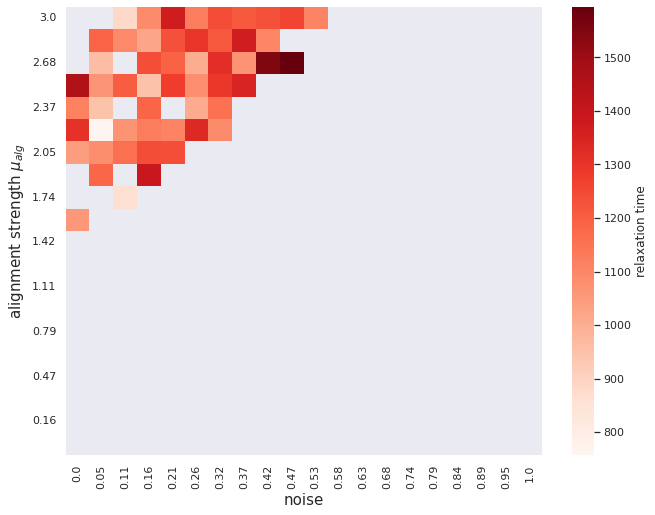

In [18]:

import seaborn as sns; sns.set_theme()
import pandas as pd
import matplotlib.pyplot as plt

steps = 20

paraChange1_val = np.linspace(0,3,steps)
paraChange2_val = np.linspace(0,1,steps)


df = pd.DataFrame(np.flip(reltime_mean, axis = 0))

df.columns = np.round(paraChange2_val,2)
df.index = np.round(paraChange1_val,2)[::-1]


#plt.title(figname, fontsize = 12, pad = 20) # title with fontsize 20
ax = sns.heatmap(df, cbar_kws={'label': "relaxation time"},
                 cmap="Reds")

plt.tight_layout()
plt.gcf().set_size_inches(10,7.85)
plt.xlabel("noise", fontsize = 15) # x-axis label with fontsize 15
plt.ylabel("alignment strength " + u'$μ_{alg}$', fontsize = 15) # y-axis label with fontsize 15

In [7]:
print(paraChange1_val, paraChange2_val)

[0.         0.15789474 0.31578947 0.47368421 0.63157895 0.78947368
 0.94736842 1.10526316 1.26315789 1.42105263 1.57894737 1.73684211
 1.89473684 2.05263158 2.21052632 2.36842105 2.52631579 2.68421053
 2.84210526 3.        ] [0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]


In [49]:
front_rel_set.max()

2169.0

In [50]:
front_rel_set = front_rel_hm[19,4,:]
side_rel_set = side_rel_hm[19,4,:]
back_rel_set = back_rel_hm[19,4,:]

front_rel_set = front_rel_set[~np.isnan(front_rel_set)]
front_rel_set = front_rel_set[front_rel_set<perc_75]

back_rel_set = back_rel_set[~np.isnan(back_rel_set)]
back_rel_set = back_rel_set[back_rel_set<perc_75]

side_rel_set = side_rel_set[~np.isnan(side_rel_set)]
side_rel_set = side_rel_set[side_rel_set<perc_75]

Text(0, 0.5, 'relaxation time')

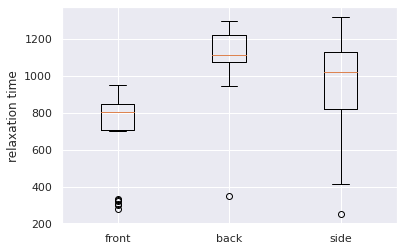

In [51]:
my_dict = {'front': front_rel_set, 'back': back_rel_set, "side": side_rel_set}

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
plt.ylabel("relaxation time")